# Forecasting
- This notebook studies the Mexican economy during three crisis episodes
1) The Mexican Peso Crisis of 1994
2) The Global Financial Crisis
3) The Covid 19 Crisis
- I evaluate whether each crisis produces a permanent decline in the Mexican economy belows its trend
- I estimate trends using two methods: 
1) Linear regression 
2) ARIMA forecasting

 

In [31]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pmdarima



# Data

In [32]:
gdp = pd.read_csv('../data/mexico_fred/gdp.csv')
consumption = pd.read_csv('../data/mexico_fred/consumption.csv')
investment = pd.read_csv('../data/mexico_fred/investment.csv')
exports = pd.read_csv('../data/mexico_fred/exports.csv')
imports = pd.read_csv('../data/mexico_fred/imports.csv')

In [33]:
gdp

,DATE,NAEXKP01MXQ661S
0,1980-01-01,44.719784
1,1980-04-01,45.011521
2,1980-07-01,45.983214
3,1980-10-01,47.314826
4,1981-01-01,48.371353
...,...,...
170,2022-07-01,106.687860
171,2022-10-01,107.410851
172,2023-01-01,108.023425
173,2023-04-01,109.033048


In [34]:
consumption

,DATE,NAEXKP02MXQ661S
0,1980-01-01,44.230194
1,1980-04-01,45.002112
2,1980-07-01,46.101335
3,1980-10-01,47.231852
4,1981-01-01,47.583991
...,...,...
170,2022-07-01,108.654832
171,2022-10-01,108.905646
172,2023-01-01,111.293218
173,2023-04-01,112.051408


In [35]:
investment

,DATE,NAEXKP04MXQ661S
0,1980-01-01,44.037200
1,1980-04-01,44.998154
2,1980-07-01,46.487005
3,1980-10-01,46.967455
4,1981-01-01,51.149558
...,...,...
170,2022-07-01,92.988415
171,2022-10-01,97.579086
172,2023-01-01,104.559448
173,2023-04-01,111.783238


In [36]:
exports

,DATE,NAEXKP06MXQ661S
0,1980-01-01,7.015216
1,1980-04-01,7.229705
2,1980-07-01,7.382709
3,1980-10-01,7.701244
4,1981-01-01,8.241808
...,...,...
170,2022-07-01,128.301307
171,2022-10-01,121.720476
172,2023-01-01,121.119517
173,2023-04-01,117.362783


In [37]:
imports

,DATE,NAEXKP07MXQ661S
0,1980-01-01,13.682008
1,1980-04-01,14.104567
2,1980-07-01,14.555336
3,1980-10-01,13.948098
4,1981-01-01,18.882808
...,...,...
170,2022-07-01,127.683237
171,2022-10-01,125.795541
172,2023-01-01,132.146848
173,2023-04-01,133.079054


In [38]:
gdp.columns           = ['date', 'GDP']
consumption.columns   = ['date', 'C']
investment.columns    = ['date', 'I']
exports.columns       = ['date', 'X']
imports.columns       = ['date', 'M']

In [39]:
df = (
    gdp.merge(consumption, on='date')
    .merge(investment, on='date')
    .merge(exports, on='date')
    .merge(imports, on='date')
)
df['date'] = pd.to_datetime(df['date'])

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    175 non-null    datetime64[ns]
 1   GDP     175 non-null    float64       
 2   C       175 non-null    float64       
 3   I       175 non-null    float64       
 4   X       175 non-null    float64       
 5   M       175 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 8.3 KB


array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

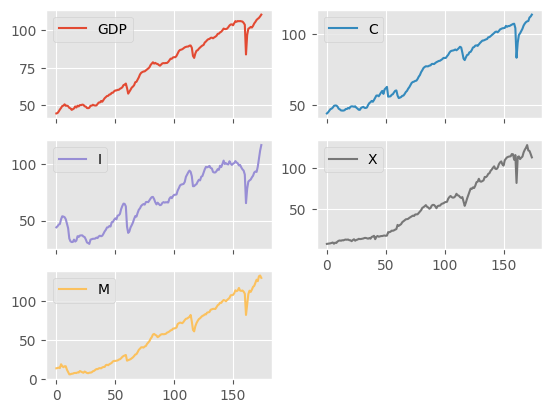

In [41]:
df[['GDP', 'C', 'I', 'X', 'M']].plot(subplots=True, layout=(3,2))

In [42]:
# taking logs converts the exponential growth trend to be linear
tolog = ['GDP', 'C', 'I', 'X', 'M']
for var in tolog:
    df[var] = np.log(df[var])

df = df.set_index('date')
# normalize by 1990 period
for var in ['GDP', 'C', 'I', 'X', 'M']:
    df[var] = 100 * df[var] / df[var][pd.to_datetime('1990')]
df = df.reset_index()

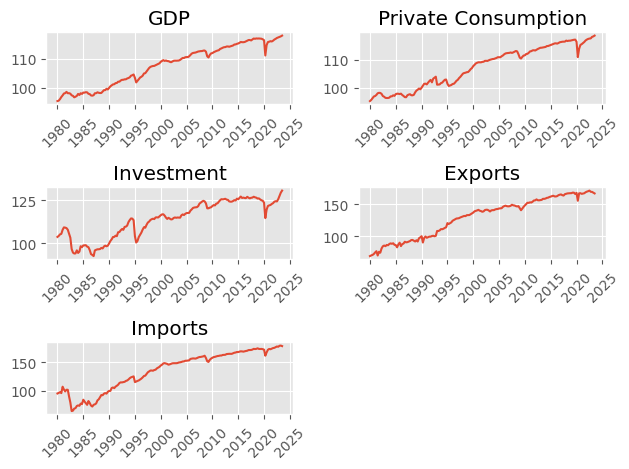

In [43]:
plt.subplot(321)
plt.plot(df['date'], df['GDP'])
plt.xticks(rotation=45)
plt.title('GDP')

plt.subplot(322)
plt.plot(df['date'], df['C'])
plt.xticks(rotation=45)
plt.title('Private Consumption')

plt.subplot(323)
plt.plot(df['date'], df['I'])
plt.xticks(rotation=45)
plt.title('Investment')

plt.subplot(324)
plt.plot(df['date'], df['X'])
plt.xticks(rotation=45)
plt.title('Exports')

plt.subplot(325)
plt.plot(df['date'], df['M'])
plt.xticks(rotation=45)
plt.title('Imports')

plt.tight_layout()

In [44]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

def min_max_estimator(df, y, startdate_range, enddate):
    """
    This function produces a range linear regressions.
    The linear regressions are estimated over y from startdate to enddate
    where startdate is a range of dates within startdate_range

    The 'min' regression estimate is the minimum of all regression estimates.
    The 'max' regression estimate is the maximum of all regression estimates.
    """
    predictions = pd.DataFrame()
    for startdate in startdate_range:
        df_train = df[(df.date >= startdate) & (df.date <= enddate)]
        df_train['index'] = df_train.index
        model = smf.ols(formula = y + ' ~ index', data=df_train)    
        fit = model.fit()
        predictions[startdate] = fit.predict(df)
    min = predictions.min(axis=1)
    max = predictions.max(axis=1)
    return min, max

alpha = 0.20
CI = str(int(100*(1 - alpha))) + '% C.I.'

def get_pred_conf(arima, nperiods, alpha=alpha):
    """Generate nperiods ahead prediction and confidence interval of arima model

    Args:
        arima (pmdarima.arima): arima model
        nperiods (int): number of periods ahead to forecast
        alpha (float): return (1-alpha)% confidence interval

    Returns:
        prediction (pd.DataFrame): forecast prediction
        confidence_interval (pd.DataFrame): dataframe of lower and upper confidence intervals
        _type_: _description_
    """
    prediction, conf = arima.predict(nperiods, return_conf_int=True, alpha=alpha)
    confidence_interval = pd.DataFrame(index=prediction.index)
    confidence_interval['lower'] = conf[:, 0]
    confidence_interval['upper'] = conf[:, 1]
    return prediction, confidence_interval

In [45]:
forecast = {
    'color':'blue',
    'alpha':0.15
}

df['index'] = df.index

# Mexican Peso Crisis

This section produces forecasts for national accounts during the Mexican Peso Crisis. 
- Using the Min-Max method, we can see GDP, consumption, and imports all recover to their trend forecast. Investment features a larger forecast confidence interval due to its initial decrease during the 1980s and increase in the late 1980s. 
- Exports increases above trend.
Why the increase in exports? We can attribute this to the exchange rate devaluation we observed at the time. This makes Mexican exports relatively cheap in the world economy, boosting their demand.
- The ARIMA method similarly shows that GDP, consumption, and imports recover to their trend levels, whereas exports stays above its trend level.
- Interestingly, ARIMA predicts that investment decreases following the training period. Why? Investment in Mexico was so stagnant during the 1980s that ARIMA does not see a long run growth trend, and views the increase in the late 1980s as purely transitory. We can see this in the specified ARIMA model for investment, which does not include any differing terms to induce stationarity.

In [46]:
startdate_range = pd.date_range(pd.to_datetime('1980Q1'), pd.to_datetime('1989Q4'), freq='Q')
enddate = pd.to_datetime('1992Q4')

regmin = {}
regmax = {}

for var in ['GDP', 'C', 'I', 'X', 'M']:
    regmin[var], regmax[var] = min_max_estimator(df, var, startdate_range, enddate)

/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_18143/281601274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index'] = df_train.index
/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_18143/281601274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index'] = df_train.index
/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_18143/281601274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

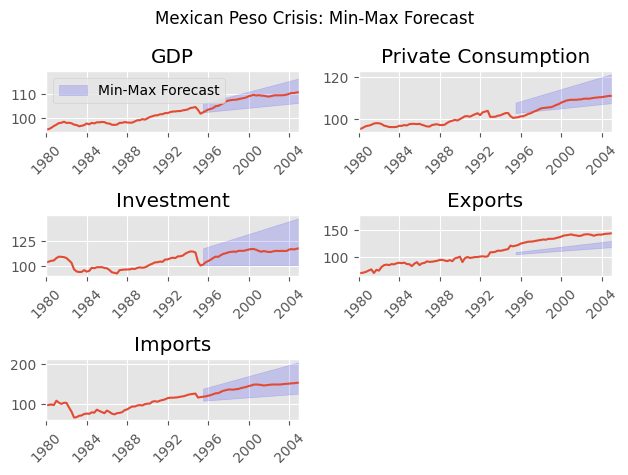

In [47]:
xmin = pd.to_datetime('1980')
xmax = pd.to_datetime('2005')
crisis = pd.to_datetime('1995Q2')

post = (df['date'] > crisis) & (df['date'] <= xmax)

plt.suptitle('Mexican Peso Crisis: Min-Max Forecast')

plt.subplot(321)
plt.plot(df.date, df['GDP'])
plt.fill_between(df.date[post], regmin['GDP'][post], regmax['GDP'][post], **forecast, 
                 label='Min-Max Forecast')
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('GDP')
plt.legend()

plt.subplot(322)
plt.plot(df.date, df['C'])
plt.fill_between(df.date[post], regmin['C'][post], regmax['C'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Private Consumption')

plt.subplot(323)
plt.plot(df.date, df['I'])
plt.fill_between(df.date[post], regmin['I'][post], regmax['I'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Investment')

plt.subplot(324)
plt.plot(df.date, df['X'])
plt.fill_between(df.date[post], regmin['X'][post], regmax['X'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Exports')

plt.subplot(325)
plt.plot(df.date, df['M'])
plt.fill_between(df.date[post], regmin['M'][post], regmax['M'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Imports')

plt.tight_layout()

In [48]:
import pmdarima as pm

enddate = pd.to_datetime('1992Q4')
train = df.query('date <= @enddate')

arima = {}
pred = {}
conf_int = {}

arima['GDP'] = pm.auto_arima(train['GDP'], start_p=1, start_q=1, seasonal=False)
arima['C'] = pm.auto_arima(train['C'], start_p=1, start_q=1, seasonal=False)
arima['I'] = pm.auto_arima(train['I'], start_p=1, start_q=1, seasonal=False)
arima['X'] = pm.auto_arima(train['X'], start_p=1, start_q=1, seasonal=False)
arima['M'] = pm.auto_arima(train['M'], start_p=1, start_q=1, seasonal=False)

pred['GDP'], conf_int['GDP'] = get_pred_conf(arima['GDP'], 40)
pred['C'], conf_int['C'] = get_pred_conf(arima['C'], 40)
pred['I'], conf_int['I'] = get_pred_conf(arima['I'], 40)
pred['X'], conf_int['X'] = get_pred_conf(arima['X'], 40)
pred['M'], conf_int['M'] = get_pred_conf(arima['M'], 40)

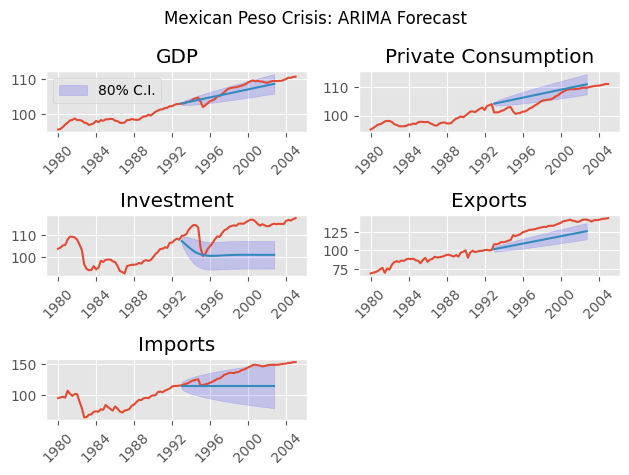

In [49]:
xrotation = 45
focus = df.query('date <= 2005')

plt.suptitle('Mexican Peso Crisis: ARIMA Forecast')

plt.subplot(321)
plt.title('GDP')
plt.plot(focus.date, focus['GDP'])
plt.plot(focus.date[pred['GDP'].index], pred['GDP'])
plt.fill_between(focus.date[conf_int['GDP'].index], conf_int['GDP'].lower, conf_int['GDP'].upper, **forecast, 
                 label=CI)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(322)
plt.title('Private Consumption')
plt.plot(focus.date, focus['C'])
plt.plot(focus.date[pred['C'].index], pred['C'])
plt.fill_between(focus.date[conf_int['C'].index], conf_int['C'].lower, conf_int['C'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(323)
plt.title('Investment')
plt.plot(focus.date, focus['I'])
plt.plot(focus.date[pred['I'].index], pred['I'])
plt.fill_between(focus.date[conf_int['I'].index], conf_int['I'].lower, conf_int['I'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(324)
plt.title('Exports')
plt.plot(focus.date, focus['X'])
plt.plot(focus.date[pred['X'].index], pred['X'])
plt.fill_between(focus.date[conf_int['X'].index], conf_int['X'].lower, conf_int['X'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(325)
plt.title('Imports')
plt.plot(focus.date, focus['M'])
plt.plot(focus.date[pred['M'].index], pred['M'])
plt.fill_between(focus.date[conf_int['M'].index], conf_int['M'].lower, conf_int['M'].upper, **forecast)
plt.xticks(rotation=45)

plt.tight_layout()

In [50]:
arima['I'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   52
Model:               SARIMAX(3, 0, 0)   Log Likelihood                 -89.438
Date:                Tue, 30 Jan 2024   AIC                            188.876
Time:                        12:30:54   BIC                            198.632
Sample:                             0   HQIC                           192.616
                                 - 52                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.1284      4.639      1.968      0.049       0.036      18.220
ar.L1          1.2591      0.174      7.233      0.000       0.918       1.600
ar.L2         -0.0998      0.291     -0.342      0.732      -0.671       0.471
ar.L3         -0.2496      0.176     -1.421      0.155      -0.594       0.095
sigma2         1.7251      0.301      5.736      0.000       1.136       2.315
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                18.77
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -0.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Global Financial Crisis

This section produces forecasts for national accounts during the global financial crisis.
- Examining the Min-Max forecast, we can see that GDP, consumption, investment and imports display weak recoveries.
- The ARIMA forecasts similarly predict weak recoveries of GDP, consumption, and exports. Imports displays a stronger recovery, while investment stagnates.

In [51]:
startdate_range = pd.date_range(pd.to_datetime('1995Q1'), pd.to_datetime('2005Q1'), freq='Q')
enddate = pd.to_datetime('2007Q4')

regmin = {}
regmax = {}

for var in ['GDP', 'C', 'I', 'X', 'M']:
    regmin[var], regmax[var] = min_max_estimator(df, var, startdate_range, enddate)

/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_18143/281601274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index'] = df_train.index
/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_18143/281601274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index'] = df_train.index
/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_18143/281601274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

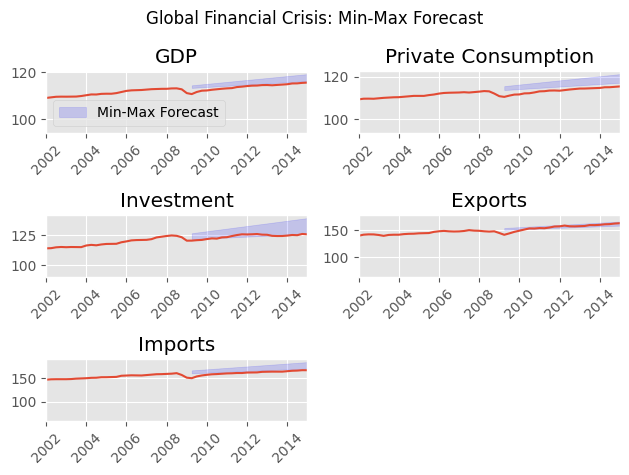

In [52]:
xmin = pd.to_datetime('2002')
xmax = pd.to_datetime('2015')
crisis = pd.to_datetime('2009Q1')

post = (df['date'] > crisis) & (df['date'] <= xmax)

plt.suptitle('Global Financial Crisis: Min-Max Forecast')

plt.subplot(321)
plt.plot(df.date, df['GDP'])
plt.fill_between(df.date[post], regmin['GDP'][post], regmax['GDP'][post], **forecast, 
                 label='Min-Max Forecast')
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('GDP')
plt.legend()

plt.subplot(322)
plt.plot(df.date, df['C'])
plt.fill_between(df.date[post], regmin['C'][post], regmax['C'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Private Consumption')

plt.subplot(323)
plt.plot(df.date, df['I'])
plt.fill_between(df.date[post], regmin['I'][post], regmax['I'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Investment')

plt.subplot(324)
plt.plot(df.date, df['X'])
plt.fill_between(df.date[post], regmin['X'][post], regmax['X'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Exports')

plt.subplot(325)
plt.plot(df.date, df['M'])
plt.fill_between(df.date[post], regmin['M'][post], regmax['M'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Imports')

plt.tight_layout()

In [53]:
import pmdarima as pm

enddate = pd.to_datetime('2007Q4')
train = df.query('date <= @enddate')

arima = {}
pred = {}
conf_int = {}

arima['GDP'] = pm.auto_arima(train['GDP'], start_p=1, start_q=1, seasonal=False)
arima['C'] = pm.auto_arima(train['C'], start_p=1, start_q=1, seasonal=False)
arima['I'] = pm.auto_arima(train['I'], start_p=1, start_q=1, seasonal=False)
arima['X'] = pm.auto_arima(train['X'], start_p=1, start_q=1, seasonal=False)
arima['M'] = pm.auto_arima(train['M'], start_p=1, start_q=1, seasonal=False)

pred['GDP'], conf_int['GDP'] = get_pred_conf(arima['GDP'], 40)
pred['C'], conf_int['C'] = get_pred_conf(arima['C'], 40)
pred['I'], conf_int['I'] = get_pred_conf(arima['I'], 40)
pred['X'], conf_int['X'] = get_pred_conf(arima['X'], 40)
pred['M'], conf_int['M'] = get_pred_conf(arima['M'], 40)

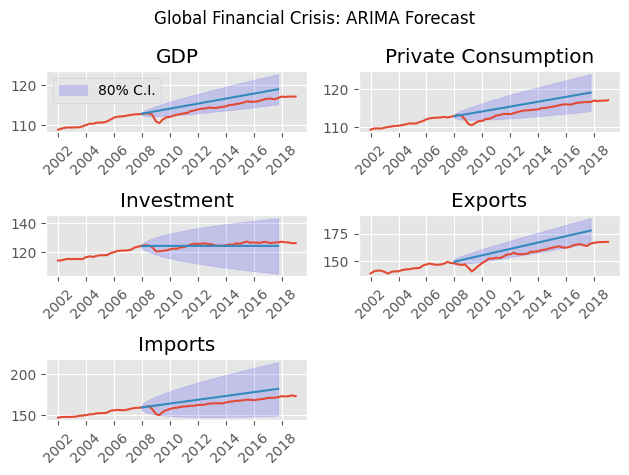

In [54]:
xrotation = 45
focus = df.query('date >= 2002').query('date <= 2019')

plt.suptitle('Global Financial Crisis: ARIMA Forecast')

plt.subplot(321)
plt.title('GDP')
plt.plot(focus.date, focus['GDP'])
plt.plot(focus.date[pred['GDP'].index], pred['GDP'])
plt.fill_between(focus.date[conf_int['GDP'].index], conf_int['GDP'].lower, conf_int['GDP'].upper, **forecast, 
                 label=CI)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(322)
plt.title('Private Consumption')
plt.plot(focus.date, focus['C'])
plt.plot(focus.date[pred['C'].index], pred['C'])
plt.fill_between(focus.date[conf_int['C'].index], conf_int['C'].lower, conf_int['C'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(323)
plt.title('Investment')
plt.plot(focus.date, focus['I'])
plt.plot(focus.date[pred['I'].index], pred['I'])
plt.fill_between(focus.date[conf_int['I'].index], conf_int['I'].lower, conf_int['I'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(324)
plt.title('Exports')
plt.plot(focus.date, focus['X'])
plt.plot(focus.date[pred['X'].index], pred['X'])
plt.fill_between(focus.date[conf_int['X'].index], conf_int['X'].lower, conf_int['X'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(325)
plt.title('Imports')
plt.plot(focus.date, focus['M'])
plt.plot(focus.date[pred['M'].index], pred['M'])
plt.fill_between(focus.date[conf_int['M'].index], conf_int['M'].lower, conf_int['M'].upper, **forecast)
plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig('../fig/gfc_arima.png', dpi=300)

# Covid 19 Crisis

This section produces forecasts for national accounts during the Covid 19 Crisis.
- All variables fail to recover to their trend, with the exception of investment, which was stagnant in the late 2010s.
- Similarly, all variables except investment are below their ARIMA forecast. 

In [55]:
startdate_range = pd.date_range(pd.to_datetime('2010Q1'), pd.to_datetime('2017Q1'), freq='Q')
enddate = pd.to_datetime('2019Q1')

regmin = {}
regmax = {}

for var in ['GDP', 'C', 'I', 'X', 'M']:
    regmin[var], regmax[var] = min_max_estimator(df, var, startdate_range, enddate)

/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_18143/281601274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index'] = df_train.index
/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_18143/281601274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index'] = df_train.index
/var/folders/_2/m9bwbkc51wl1nrm6h52gx_300000gn/T/ipykernel_18143/281601274.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

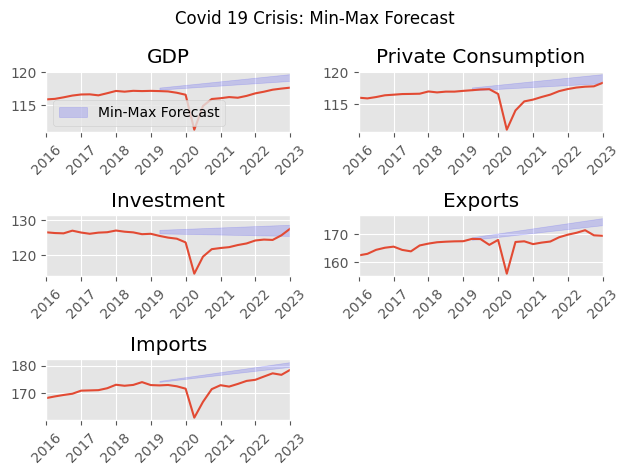

In [56]:
xmin = pd.to_datetime('2016')
xmax = pd.to_datetime('2023')
crisis = pd.to_datetime('2019Q1')

post = (df['date'] > crisis) & (df['date'] <= xmax)
focus = df[df.date >= xmin]

plt.suptitle('Covid 19 Crisis: Min-Max Forecast')

plt.subplot(321)
plt.plot(focus.date, focus['GDP'])
plt.fill_between(focus.date[post], regmin['GDP'][post], regmax['GDP'][post], **forecast, 
                 label='Min-Max Forecast')
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('GDP')
plt.legend()

plt.subplot(322)
plt.plot(focus.date, focus['C'])
plt.fill_between(focus.date[post], regmin['C'][post], regmax['C'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Private Consumption')

plt.subplot(323)
plt.plot(focus.date, focus['I'])
plt.fill_between(focus.date[post], regmin['I'][post], regmax['I'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Investment')

plt.subplot(324)
plt.plot(focus.date, focus['X'])
plt.fill_between(focus.date[post], regmin['X'][post], regmax['X'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Exports')

plt.subplot(325)
plt.plot(focus.date, focus['M'])
plt.fill_between(focus.date[post], regmin['M'][post], regmax['M'][post], **forecast)
plt.xticks(rotation=45)
plt.xlim(xmin, xmax)
plt.title('Imports')

plt.tight_layout()

In [57]:
train = df.query('date <= @enddate')

arima = {}
pred = {}
conf_int = {}

arima['GDP'] = pm.auto_arima(train['GDP'], start_p=1, start_q=1, seasonal=False)
arima['C'] = pm.auto_arima(train['C'], start_p=1, start_q=1, seasonal=False)
arima['I'] = pm.auto_arima(train['I'], start_p=1, start_q=1, seasonal=False)
arima['X'] = pm.auto_arima(train['X'], start_p=1, start_q=1, seasonal=False)
arima['M'] = pm.auto_arima(train['M'], start_p=1, start_q=1, seasonal=False)

pred['GDP'], conf_int['GDP'] = get_pred_conf(arima['GDP'], 18)
pred['C'], conf_int['C'] = get_pred_conf(arima['C'], 18)
pred['I'], conf_int['I'] = get_pred_conf(arima['I'], 18)
pred['X'], conf_int['X'] = get_pred_conf(arima['X'], 18)
pred['M'], conf_int['M'] = get_pred_conf(arima['M'], 18)

In [58]:
arima['GDP'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  157
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -50.474
Date:                Tue, 30 Jan 2024   AIC                            106.948
Time:                        12:30:58   BIC                            116.098
Sample:                             0   HQIC                           110.664
                                - 157                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0978      0.031      3.174      0.002       0.037       0.158
ar.L1          0.2941      0.046      6.388      0.000       0.204       0.384
sigma2         0.1118      0.008     14.605      0.000       0.097       0.127
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               220.69
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                            -1.29
Prob(H) (two-sided):                  0.23   Kurtosis:                         8.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

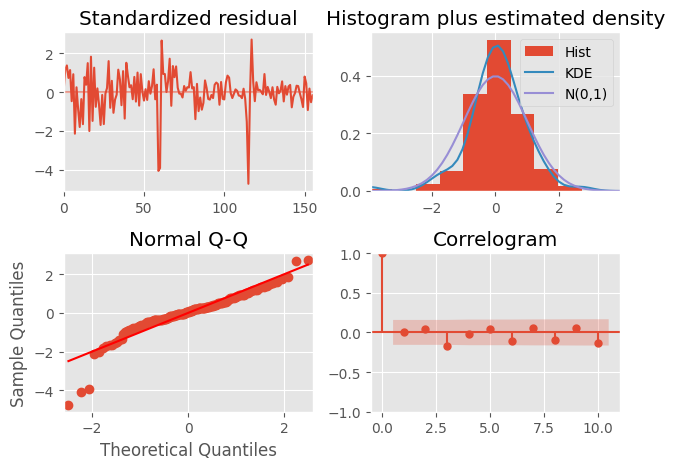

In [59]:
arima['GDP'].plot_diagnostics()
plt.tight_layout()

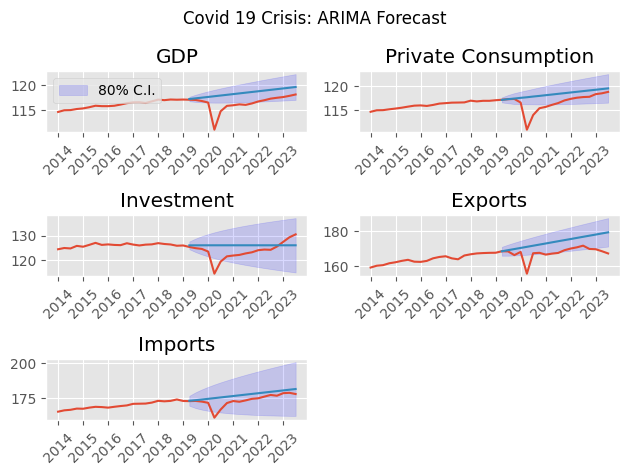

In [60]:
xrotation = 45
focus = df.query('date >= 2014')

plt.suptitle('Covid 19 Crisis: ARIMA Forecast')

plt.subplot(321)
plt.title('GDP')
plt.plot(focus.date, focus['GDP'])
plt.plot(focus.date[pred['GDP'].index], pred['GDP'])
plt.fill_between(focus.date[conf_int['GDP'].index], conf_int['GDP'].lower, conf_int['GDP'].upper, **forecast, 
                 label=CI)
plt.xticks(rotation=45)
plt.legend()

plt.subplot(322)
plt.title('Private Consumption')
plt.plot(focus.date, focus['C'])
plt.plot(focus.date[pred['C'].index], pred['C'])
plt.fill_between(focus.date[conf_int['C'].index], conf_int['C'].lower, conf_int['C'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(323)
plt.title('Investment')
plt.plot(focus.date, focus['I'])
plt.plot(focus.date[pred['I'].index], pred['I'])
plt.fill_between(focus.date[conf_int['I'].index], conf_int['I'].lower, conf_int['I'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(324)
plt.title('Exports')
plt.plot(focus.date, focus['X'])
plt.plot(focus.date[pred['X'].index], pred['X'])
plt.fill_between(focus.date[conf_int['X'].index], conf_int['X'].lower, conf_int['X'].upper, **forecast)
plt.xticks(rotation=45)

plt.subplot(325)
plt.title('Imports')
plt.plot(focus.date, focus['M'])
plt.plot(focus.date[pred['M'].index], pred['M'])
plt.fill_between(focus.date[conf_int['M'].index], conf_int['M'].lower, conf_int['M'].upper, **forecast)
plt.xticks(rotation=45)

plt.tight_layout()

plt.savefig('../fig/covid19_arima.png', dpi=300)